#### Import Module

In [4]:
import pandas as pd
import numpy as np
from data_generator_AE import DataGenerator
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn import metrics
from easydict import EasyDict
import time
import os

#### GPU Set & Check

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(tf.test.is_gpu_available())
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

True


#### Set argument

In [6]:
args = EasyDict({
    'dir_path' : r"D:\Anomaly-Dataset", ## 1: C:\Users\VIP444\Documents\Anomaly-Dataset, 2: D:\Anomaly-Dataset\sar400_vibration_data
    'train_mode' : ("Train", "Validation", "Test"),
    'batch_size' : 128,
    'split' : (0.8, 0.1, 0.1),
    'is_cache' : True,
    'is_predict' : True,
    'is_normalize' : False,
    'is_lstm' : True,
    'is_adjust_fit' : (True, False),
    'model_name' : 'LSTM'
})

#### DataGenerator

In [7]:
train_dataset = DataGenerator(
    dataset_path=args.dir_path,
    train_mode=args.train_mode[0],
    batch_size=args.batch_size,
    split=args.split,
    is_cache=args.is_cache,
    is_normalize=args.is_normalize,
    is_lstm=args.is_lstm,
    is_adjust_fit=args.is_adjust_fit[0]
)

train_dataset.__getitem__(0)
pipeline = train_dataset.pipeline

validation_dataset = DataGenerator(
    dataset_path=args.dir_path,
    train_mode=args.train_mode[1],
    batch_size=args.batch_size,
    split=args.split,
    is_cache=args.is_cache,
    is_normalize=args.is_normalize,
    is_lstm=args.is_lstm,
    is_adjust_fit=args.is_adjust_fit[1],
    pipeline=pipeline
)

test_dataset = DataGenerator(
    dataset_path=args.dir_path,
    train_mode=args.train_mode[2],
    batch_size=args.batch_size,
    split=args.split,
    is_cache=args.is_cache,
    is_normalize=args.is_normalize,
    is_lstm=args.is_lstm,
    is_predict=args.is_predict,
    is_adjust_fit=args.is_adjust_fit[1],
    pipeline=pipeline
)

#### Check dataset length

In [8]:
print(len(train_dataset.data_paths))
print(len(validation_dataset.data_paths))
print(len(test_dataset.data_paths))

6252
781
5059


#### Model Create & Compile

In [9]:
from ae_LSTM import autoencoder_model
# from models.ae_Dense import autoencoder_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

if args.is_lstm:
    input_shape = (1, 4)
else:
    input_shape = (4, )

model = autoencoder_model(input_shape)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=Huber(), metrics=['mse'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 64)             17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 32)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 64)             24832     
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 4)              260   

#### Model Train

In [69]:
epochs = 100

EXPERIMENT_DIR = f"./training_logs/{time.strftime('%Y-%m-%d-%H%M%S')}-{args.model_name}"
os.makedirs(EXPERIMENT_DIR, exist_ok=True)

checkpoint_path = EXPERIMENT_DIR + "/model/checkpoint.pt"
os.makedirs(EXPERIMENT_DIR + "/model", exist_ok=True)

callbacks = [
    # EarlyStopping(monitor='val_loss', patience=7, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=6,verbose=1, min_lr=1e-3 * 1e-1),
    CSVLogger(EXPERIMENT_DIR + '/train_log.csv', separator=',', append=True),
    ]

history = model.fit(train_dataset, validation_data=(validation_dataset), epochs=epochs, batch_size=args.batch_size, callbacks=callbacks).history
model.load_weights(checkpoint_path)
model.save(EXPERIMENT_DIR + "/model/model.h5")

Epoch 1/100
25/25 [==============================] - 3s 36ms/step - loss: 0.9312 - mse: 3.0028 - val_loss: 0.9074 - val_mse: 2.9111

Epoch 00001: val_loss improved from inf to 0.90745, saving model to ./training_logs/2022-07-18-153743-LSTM/model\checkpoint.pt
Epoch 2/100
25/25 [==============================] - 1s 22ms/step - loss: 0.8912 - mse: 2.8551 - val_loss: 0.8379 - val_mse: 2.6553

Epoch 00002: val_loss improved from 0.90745 to 0.83786, saving model to ./training_logs/2022-07-18-153743-LSTM/model\checkpoint.pt
Epoch 3/100
25/25 [==============================] - 0s 20ms/step - loss: 0.6462 - mse: 1.9574 - val_loss: 0.4722 - val_mse: 1.2950

Epoch 00003: val_loss improved from 0.83786 to 0.47221, saving model to ./training_logs/2022-07-18-153743-LSTM/model\checkpoint.pt
Epoch 4/100
25/25 [==============================] - 0s 19ms/step - loss: 0.3497 - mse: 0.9029 - val_loss: 0.2268 - val_mse: 0.5562

Epoch 00004: val_loss improved from 0.47221 to 0.22678, saving model to ./train

#### Visualize Learning Tendency

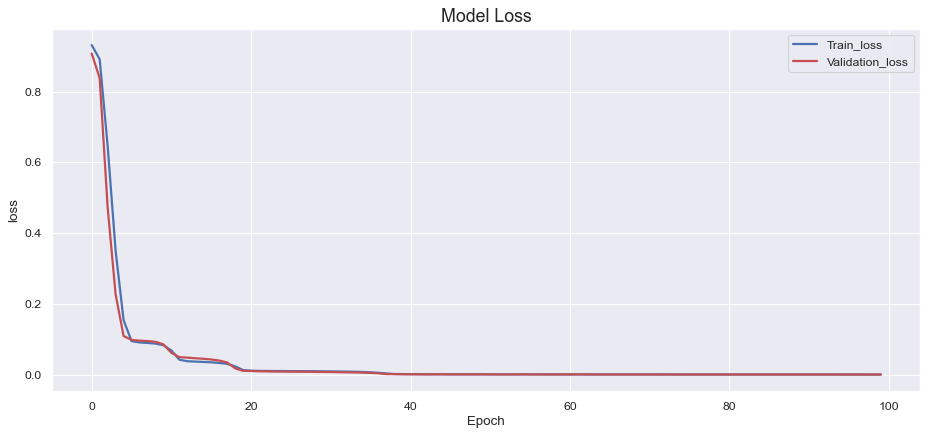

In [70]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train_loss', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation_loss', linewidth=2)
ax.set_title('Model Loss', fontsize=16)
ax.set_ylabel('loss')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

#### Model evaluate

In [ ]:
loss = model.evaluate(test_dataset, verbose=1)
print(loss)

#### Predict Test dataset

In [71]:
predict = model.predict(test_dataset, verbose=1)
print(predict.shape)

20/20 [==============================] - 0s 3ms/step
(5059, 1, 4)


#### Predict Validation dataset for calculate threshold

In [72]:
validation_dataset.is_predict = True
predict_val = model.predict(validation_dataset, verbose=1)
print(predict_val.shape)

4/4 [==============================] - 0s 0s/step
(781, 1, 4)


#### Predict data reshape for analysis

In [73]:
predict = predict.reshape(predict.shape[0], predict.shape[2])
predict_val = predict_val.reshape(predict_val.shape[0], predict_val.shape[2])

print(predict.shape)
print(predict_val.shape)

(5059, 4)
(781, 4)


#### Load original validation data

In [74]:
keys = list(train_dataset.cache.keys())

train_data = np.array([row for key in keys for row in train_dataset.cache[key][0]])
train_data = train_data.reshape(train_data.shape[0], train_data.shape[2])[:,0]

keys = list(validation_dataset.cache.keys())

validation_data = np.array([row for key in keys for row in validation_dataset.cache[key][0]])
validation_data = validation_data.reshape(validation_data.shape[0], validation_data.shape[2])

keys = list(test_dataset.cache.keys())

test_data = np.array([row for key in keys for row in test_dataset.cache[key]])
test_data = test_data.reshape(test_data.shape[0], test_data.shape[2])

# display_data(train_data, validation_data, test_data)

#### Calculate threshold use precision_recall_curve

1.0
1.0
3.601933811906986e-06


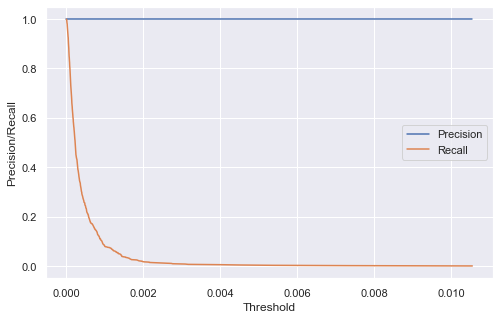

In [77]:
mse = np.mean(np.power(validation_data - predict_val, 2), axis=1)
mae = np.mean(np.abs(validation_data - predict_val), axis=1)

test_mse = np.mean(np.power(test_data - predict, 2), axis=1)
test_mae = np.mean(np.abs(test_data - predict), axis=1)

y_valid = np.ones(len(validation_data))
y_test = [label[0] for label in test_dataset.predict_labels]

error_df_mse = pd.DataFrame({'Reconstruction_error' : mse, 'True_class': y_valid})
error_df_mae = pd.DataFrame({'Reconstruction_error' : mae, 'True_class': y_valid})
error_test_df_mse = pd.DataFrame(({'Reconstruction_error' : test_mse, 'True_class': y_test}))
error_test_df_mae = pd.DataFrame(({'Reconstruction_error' : test_mae, 'True_class': y_test}))

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df_mse['True_class'], error_df_mse['Reconstruction_error'])

best_cnt_dic = abs(precision_rt - recall_rt)
threshold = threshold_rt[np.argmin(best_cnt_dic)]

print(precision_rt[np.argmin(best_cnt_dic)])
print(recall_rt[np.argmin(best_cnt_dic)])
print(threshold)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
# model = tf.keras.models.load_model('model/model_loss_test.h5')

# X_pred = model.predict(X_train)

# X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2]) 
# X_pred = pd.DataFrame(X_pred)

# Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2]) 

# scored = pd.DataFrame()
# scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis=1)
# # scored['Loss_mae'] = np.mean(X_pred-Xtrain, axis=1) 

# Threshold = 0.017

# plt.figure(figsize=(16,9), dpi=80)
# plt.title('Loss Distribution', fontsize=16)
# plt.xlim([0,1])
# sns.distplot(scored['Loss_mae'], kde= True, color = 'blue')

#### Predict data to log.csv

In [93]:
threshold = np.mean(mse)*2

scored_val = pd.DataFrame()
scored_val['Loss_mse'] = mse
scored_val['Threshold'] = threshold
scored_val['Anomaly'] = scored_val['Loss_mse'] > scored_val['Threshold']
print(scored_val)

scored_val.to_csv(EXPERIMENT_DIR + '/validation_log.csv', sep=',')

     Loss_mse  Threshold  Anomaly
0    0.000230   0.000833    False
1    0.000149   0.000833    False
2    0.000158   0.000833    False
3    0.000901   0.000833     True
4    0.000235   0.000833    False
..        ...        ...      ...
776  0.000205   0.000833    False
777  0.001976   0.000833     True
778  0.000168   0.000833    False
779  0.000615   0.000833    False
780  0.000034   0.000833    False

[781 rows x 3 columns]


In [94]:
X_pred = pd.DataFrame(predict)

scored = pd.DataFrame()
scored['Loss_mse'] = test_mse
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mse'] > scored['Threshold']
print(scored)

scored.to_csv(EXPERIMENT_DIR + '/test_log.csv', sep=',')

      Loss_mse  Threshold  Anomaly
0     0.000111   0.000833    False
1     0.001432   0.000833     True
2     0.000098   0.000833    False
3     0.000052   0.000833    False
4     0.000234   0.000833    False
...        ...        ...      ...
5054  0.559412   0.000833     True
5055  1.927552   0.000833     True
5056  2.505992   0.000833     True
5057  0.745082   0.000833     True
5058  1.945951   0.000833     True

[5059 rows x 3 columns]


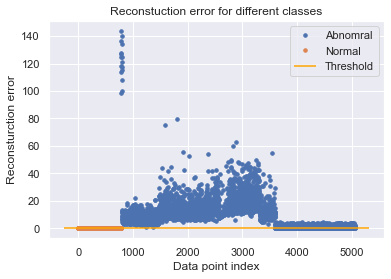

In [104]:
fig, ax = plt.subplots()
groups = error_test_df_mse.groupby("True_class")

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
    label="Abnomral" if name == 0 else "Normal")

ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors='orange', zorder=100, label="Threshold")
ax.legend()
plt.title("Reconstuction error for different classes")
plt.ylabel("Reconsturction error")
plt.xlabel("Data point index")
plt.savefig(EXPERIMENT_DIR + '\Reconstruction_error.png')
plt.show()

Test Accuracy : 97.98379126309548%


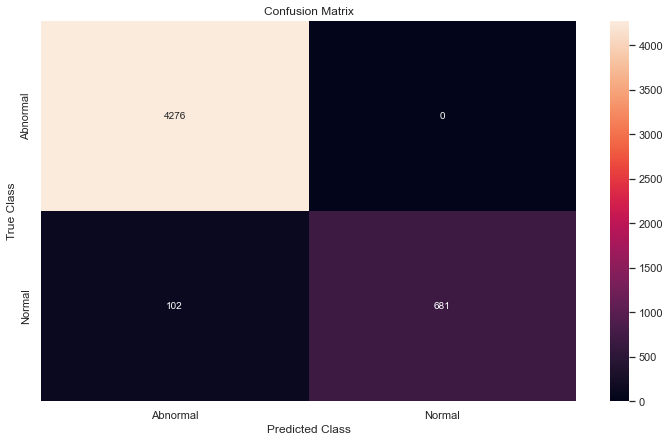

In [105]:
from sklearn.metrics import confusion_matrix

y_true = test_dataset.predict_labels
y_pred = [[0.0] if pred == True else [1.0] for pred in scored['Anomaly']]

test_accuracy = np.sum([1 if true == pred else 0 for pred, true in zip(y_pred, y_true)]) / len(y_pred)
print(f"Test Accuracy : {(test_accuracy*100)}%")

cm = confusion_matrix(y_true, y_pred)
labels = ["Abnormal", "Normal"]

plt.figure(figsize = (12,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.savefig(EXPERIMENT_DIR + '\confusion_matrix.png')